In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

COOLING_DUMMY_BALANCE_POINT = 150.
HEATING_DUMMY_BALANCE_POINT = 0.

### Data description:
This notebook uses the normalized annual results for three different sets of balance points:
- coarse: our original three balance points (65, 70, 75 for cooling; 55, 60, 65 for heating)
- fine: same ranges as the coarse balance points but with stepsize of 1 degree
- fine wide: one degree stepsize between 60-80 for cooling and 50-70 for heating

In [2]:
%store -r coarse_results
%store -r fine_results
%store -r fine_results_wide

In [3]:
coarse_results.describe()

,Savings,pre hbp,pre cbp,post hbp,post cbp
count,2601.000000,2601.000000,2601.000000,2601.000000,2601.000000
mean,134.207035,38.454441,105.257593,33.010381,105.561323
std,2023.648233,29.263963,40.315713,31.218084,40.460239
min,-14215.824389,0.000000,65.000000,0.000000,65.000000
25%,-623.000345,0.000000,70.000000,0.000000,65.000000
50%,94.365128,55.000000,75.000000,55.000000,75.000000
75%,853.315763,65.000000,150.000000,65.000000,150.000000
max,26922.049648,65.000000,150.000000,65.000000,150.000000


In [4]:
fine_results.describe()

,Savings,pre hbp,pre cbp,post hbp,post cbp
count,2601.000000,2601.000000,2601.000000,2601.000000,2601.000000
mean,135.885332,39.192618,104.118032,33.567090,105.373702
std,2016.168507,28.952976,40.056483,31.057964,40.273052
min,-14215.824389,0.000000,65.000000,0.000000,65.000000
25%,-618.863627,0.000000,68.000000,0.000000,68.000000
50%,97.989376,55.000000,75.000000,55.000000,75.000000
75%,857.735209,63.000000,150.000000,64.000000,150.000000
max,26588.563506,65.000000,150.000000,65.000000,150.000000


In [5]:
fine_results_wide.describe()

,Savings,pre hbp,pre cbp,post hbp,post cbp
count,2601.000000,2601.000000,2601.000000,2601.000000,2601.000000
mean,105.645878,41.958093,101.405998,36.339485,102.441369
std,2052.132164,28.358545,40.073410,31.661887,40.377513
min,-14215.824389,0.000000,60.000000,0.000000,60.000000
25%,-657.163986,0.000000,68.000000,0.000000,67.000000
50%,65.463112,53.000000,74.000000,56.000000,75.000000
75%,846.899182,64.000000,150.000000,65.000000,150.000000
max,26588.563506,70.000000,150.000000,70.000000,150.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e840da0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10eeb9278>]], dtype=object)

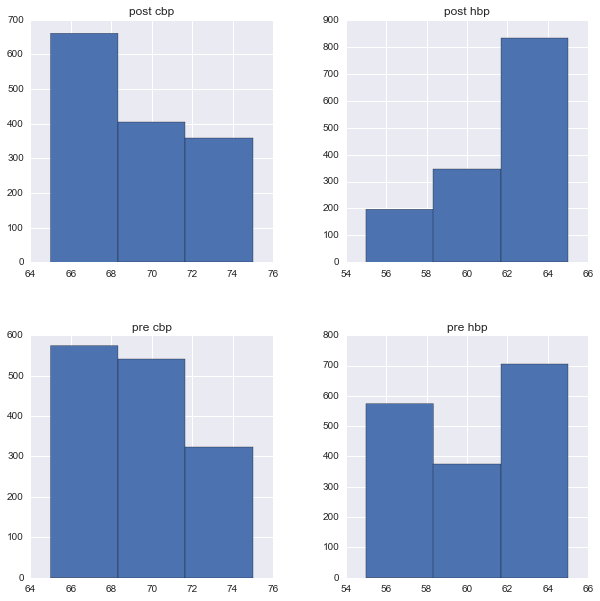

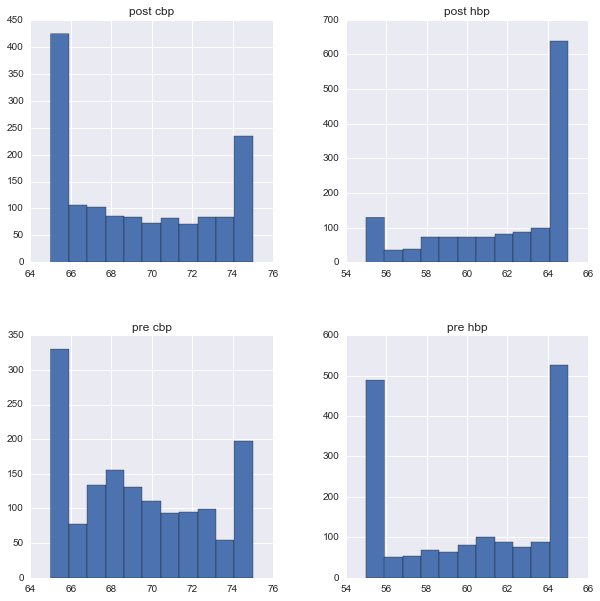

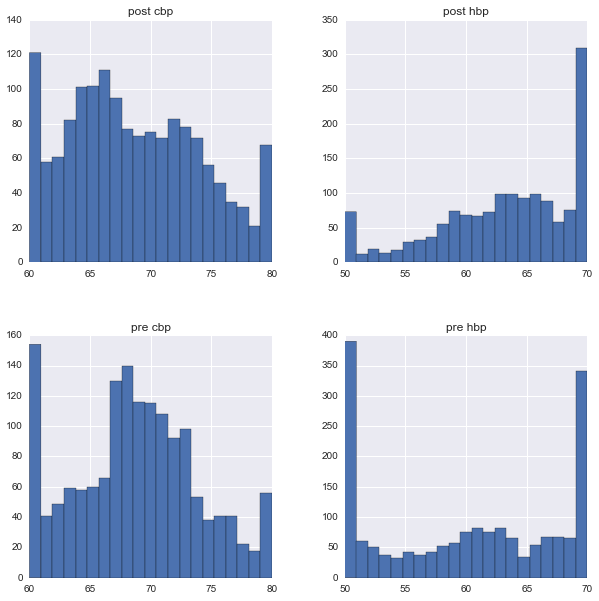

In [8]:
def remove_dummy_balance_points(df):
    '''Change the dummy heating and cooling balance points to np.nan
    '''
    return df.replace(str(HEATING_DUMMY_BALANCE_POINT), np.nan).replace(str(COOLING_DUMMY_BALANCE_POINT), np.nan)

fine_results_wide_valid = remove_dummy_balance_points(fine_results_wide)
fine_results_valid = remove_dummy_balance_points(fine_results)
coarse_results_valid = remove_dummy_balance_points(coarse_results)
coarse_results_valid.hist(['pre hbp', 'pre cbp', 'post hbp', 'post cbp'], bins=3, figsize=(10, 10))
fine_results_valid.hist(['pre hbp', 'pre cbp', 'post hbp', 'post cbp'], bins=11, figsize=(10, 10))
fine_results_wide_valid.hist(['pre hbp', 'pre cbp', 'post hbp', 'post cbp'], bins=21, figsize=(10, 10))

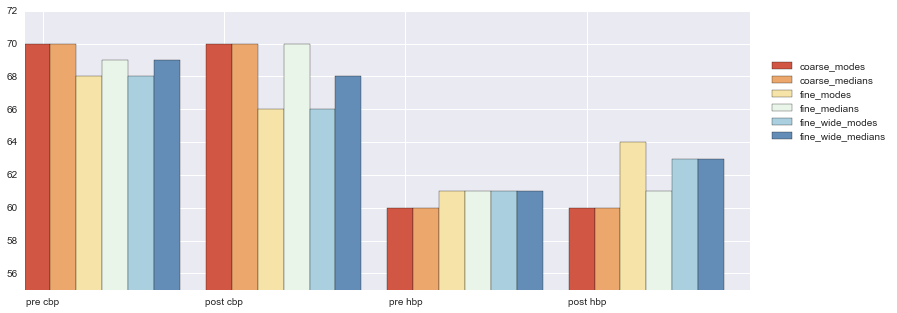

In [10]:
def get_mode_of_column(df, col_name):
    '''Get the mode of a column excluding the extreme values on the ends of the distribution.
    If there are multiple values with the same count, the first is returned.
    
    @param df: a pandas dataframe
    @param col_name: str, the name of the column to get the mode for
    @return: list with two arrays of single values; first the value of the mode, second the count of that value
    '''
    min_extreme = df[col_name].min()
    max_extreme = df[col_name].max()
    mode = stats.mode(df.ix[(df[col_name] != min_extreme) & (df[col_name] != max_extreme), col_name])
    return mode


def get_mode_for_all_balancepoints(df):
    '''Get the mode for all the balance point columns in a dataframe
    
    @param df: a pandas dataframe with columns for pre and post cbp/hbp
    @return: an array of the modes for [pre cbp, post cbp, pre hbp, post hbp]
    '''
    pre_cbp = get_mode_of_column(df, 'pre cbp')
    post_cbp = get_mode_of_column(df, 'post cbp')
    pre_hbp = get_mode_of_column(df, 'pre hbp')
    post_hbp = get_mode_of_column(df, 'post hbp')
    
    return np.concatenate([pre_cbp[0], post_cbp[0], pre_hbp[0], post_hbp[0]])


def get_median_of_column(df, col_name):
    '''Get the median of a column excluding the extreme values at the ends of the distribution.
    '''
    min_extreme = df[col_name].min()
    max_extreme = df[col_name].max()
    median = np.nanmedian(df.ix[(df[col_name] != min_extreme) & (df[col_name] != max_extreme), col_name])
    return median


def get_median_for_all_balancepoints(df):
    '''Get the median for all the balance point columns in a dataframe
    
    @param df: a pandas dataframe with columns for pre and post cbp/hbp
    @return: an array of the medians for [pre cbp, post cbp, pre hbp, post hbp]
    '''
    pre_cbp = get_median_of_column(df, 'pre cbp')
    post_cbp = get_median_of_column(df, 'post cbp')
    pre_hbp = get_median_of_column(df, 'pre hbp')
    post_hbp = get_median_of_column(df, 'post hbp')
    return [pre_cbp, post_cbp, pre_hbp, post_hbp]
    

coarse_modes = get_mode_for_all_balancepoints(coarse_results_valid)
fine_modes = get_mode_for_all_balancepoints(fine_results_valid)
fine_wide_modes = get_mode_for_all_balancepoints(fine_results_wide_valid)
coarse_medians = get_median_for_all_balancepoints(coarse_results_valid)
fine_medians = get_median_for_all_balancepoints(fine_results_valid)
fine_wide_medians = get_median_for_all_balancepoints(fine_results_wide_valid)

plt.figure(figsize=(13, 5))
palette = sns.color_palette(palette='RdYlBu', n_colors=6, desat=0.8)
bar_width = 1 / 7.
right = [coarse_modes, coarse_medians, fine_modes, fine_medians, fine_wide_modes, fine_wide_medians]
labels = ['coarse_modes', 'coarse_medians', 'fine_modes', 'fine_medians', 'fine_wide_modes', 'fine_wide_medians']
for x in range(0, 6):
    left = [0 + x * bar_width, 1 + x * bar_width, 2 + x * bar_width, 3 + x * bar_width]
    plt.bar(left, right[x], width=bar_width, color=palette[x], label=labels[x])
plt.axis([0, 4, 55, 72])
plt.xticks([0.1, 1.1, 2.1, 3.1], ['pre cbp', 'post cbp', 'pre hbp', 'post hbp'])
plt.legend(loc=1, bbox_to_anchor=(1.2, 0.85))

In [15]:
print('MODES: (pre cbp, post cbp, pre hbp, post hbp)')
print('coarse results:', coarse_modes, '\nfine results:', fine_modes, '\nfine wide results:', fine_wide_modes)
print('\nMEDIANS:')
print('coarse results:', coarse_medians,'\nfine results:', fine_medians, '\nfine wide results:', fine_wide_medians)

MODES: (pre cbp, post cbp, pre hbp, post hbp)
coarse results: [ 70.  70.  60.  60.] 
fine results: [ 68.  66.  61.  64.] 
fine wide results: [ 68.  66.  61.  63.]

MEDIANS:
coarse results: [70.0, 70.0, 60.0, 60.0] 
fine results: [69.0, 70.0, 61.0, 61.0] 
fine wide results: [69.0, 68.0, 61.0, 63.0]


### Overall impressions and discussion topics:
-  We should re-visit the chosen ranges for balance point selection (65-75 and 55-65).
-  Decide with the group what default balance points to snap to if the extreme values are selected.
-  Post treatment cooling balance point distribution is shifted to lower temperatures compared to pretreatment (this is opposite of what we expect)
-  Post treatment heating balance point distribution may be shifted to higher temperatures than pretreatment (again opposite of expected)
-  In some situations snapping to the median from the extreme values might be the wrong approach (post cbp)(?)